In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessorV3

%matplotlib inline

In [3]:
# name, epidemicforecasting.org code, OxCGRT code
region_info = [
    ("Andorra", "AD", "AND"),
    ("Austria", "AT",  "AUT"),
    ("Bosnia and Herzegovina", "BA", "BIH"),
    ("Belgium", "BE", "BEL"),
    ("Bulgaria",  "BG", "BGR"),
    ("Switzerland", "CH", "CHE"),
    ("Czech Republic", "CZ", "CZE"),
    ("Germany", "DE", "DEU"),
    ("Denmark", "DK", "DNK"),
    ("Estonia","EE", "EST"),
    ("Spain", "ES", "ESP"),
    ("Finland", "FI", "FIN"),
    ("France", "FR", "FRA"),
    ("United Kingdom", "GB", "GBR"),
    ("Greece", "GR", "GRC"),
    ("Croatia", "HR", "HRV"),
    ("Hungary", "HU", "HUN"),
    ("Ireland", "IE", "IRL"),
    ("Israel", "IL", "ISR"),
    ("Iceland", "IS", "ISL"),
    ("Italy", "IT", "ITA"),
    ("South Korea", "KR", "KOR"),
    ("Morocco", "MA", "MAR"),
    ("Mexico","MX", "MEX"),
    ("Malaysia", "MY", "MYS"),
    ("Netherlands", "NL", "NLD"),
    ("Poland","PL", "POL"),
    ("Romania","RO", "ROU"),
    ("Serbia", "RS", "SRB"),
    ("Sweden", "SE", "SWE"),
    ("Singapore", "SG", "SGP"),
    ("Slovenia", "SI", "SVN"),
    ("Slovakia", "SK", "SVK"),
    ("South Africa", "ZA",  "ZAF")
]

# OxCGRT
oxcgrt_cm_cols = ["C1_School closing", "C1_Flag", "C4_Restrictions on gatherings", "C4_Flag", "C6_Stay at home requirements",
              "C6_Flag", "H2_Testing policy", "H3_Contact tracing"]

oxcgrt_filter = [
    ("Symptomatic Testing", [(6, [2, 3])]),
    ("Public Testing", [(6, [3])]),
    ("Limited Contact Tracing", [(7, [2, 3])]),
    ("Extensive Contact Tracing", [(7, [2, 3])]),
    ("Gatherings lim. 1000", [(2, [2, 3, 4]), (3, [1])]),
    ("Gatherings lim. 100", [(2, [3, 4]), (3, [1])] ),
    ("Gatherings lim. 10", [(2, [4]), (3, [1])] ),
#     ("Some Schools Closed", [(0, [3, 2]), (1, [1])]),
    ("All Schools Closed", [(0, [3]), (1, [1])] ),
#     ("Stay at Home, Rec", [(4, [1, 2, 3]), (5, [1])] ),
    ("Stay at Home, Req", [(4, [2, 3]), (5, [1])] ),
]

epifor_features = [
 'Mask wearing over 70%',
 'Business suspended - some',
 'Business suspended - many',
 'Healthcare specialisation',
 'Outgroup mobility',
 'General curfew',
 'Gatherings limited to 1000',    
 'Gatherings limited to 100',
 'Gatherings limited to 10',
 'Schools and universities closed'
]

ox_epi = {
    'Stay at Home, Req':'General curfew',
    'Gatherings lim. 1000':'Gatherings limited to 1000',
    'Gatherings lim. 100':'Gatherings limited to 100',
    'Gatherings lim. 10':'Gatherings limited to 10',
    'All Schools Closed':'Schools and universities closed'
}

# ox_epi = dict()

final_features_ordered = [
    "Healthcare specialisation",
    "Symptomatic Testing",
    "Public Testing",
    "Limited Contact Tracing",
    "Extensive Contact Tracing",
    "Mask wearing over 70%",
    "Business suspended - some",
    "Business suspended - many",
    'Stay at Home, Req',
    'Gatherings lim. 1000',    
    'Gatherings lim. 100',
    'Gatherings lim. 10',
    'All Schools Closed',
    "Outgroup mobility"
]

dp = DataPreprocessorV3(min_num_confirmed_mask=100, min_num_active_mask=100, end_date="2020-04-20")

In [6]:
data = dp.preprocess_data("../../data", region_info, oxcgrt_filter, oxcgrt_cm_cols, epifor_features, final_features_ordered,ox_epi)

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']


KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

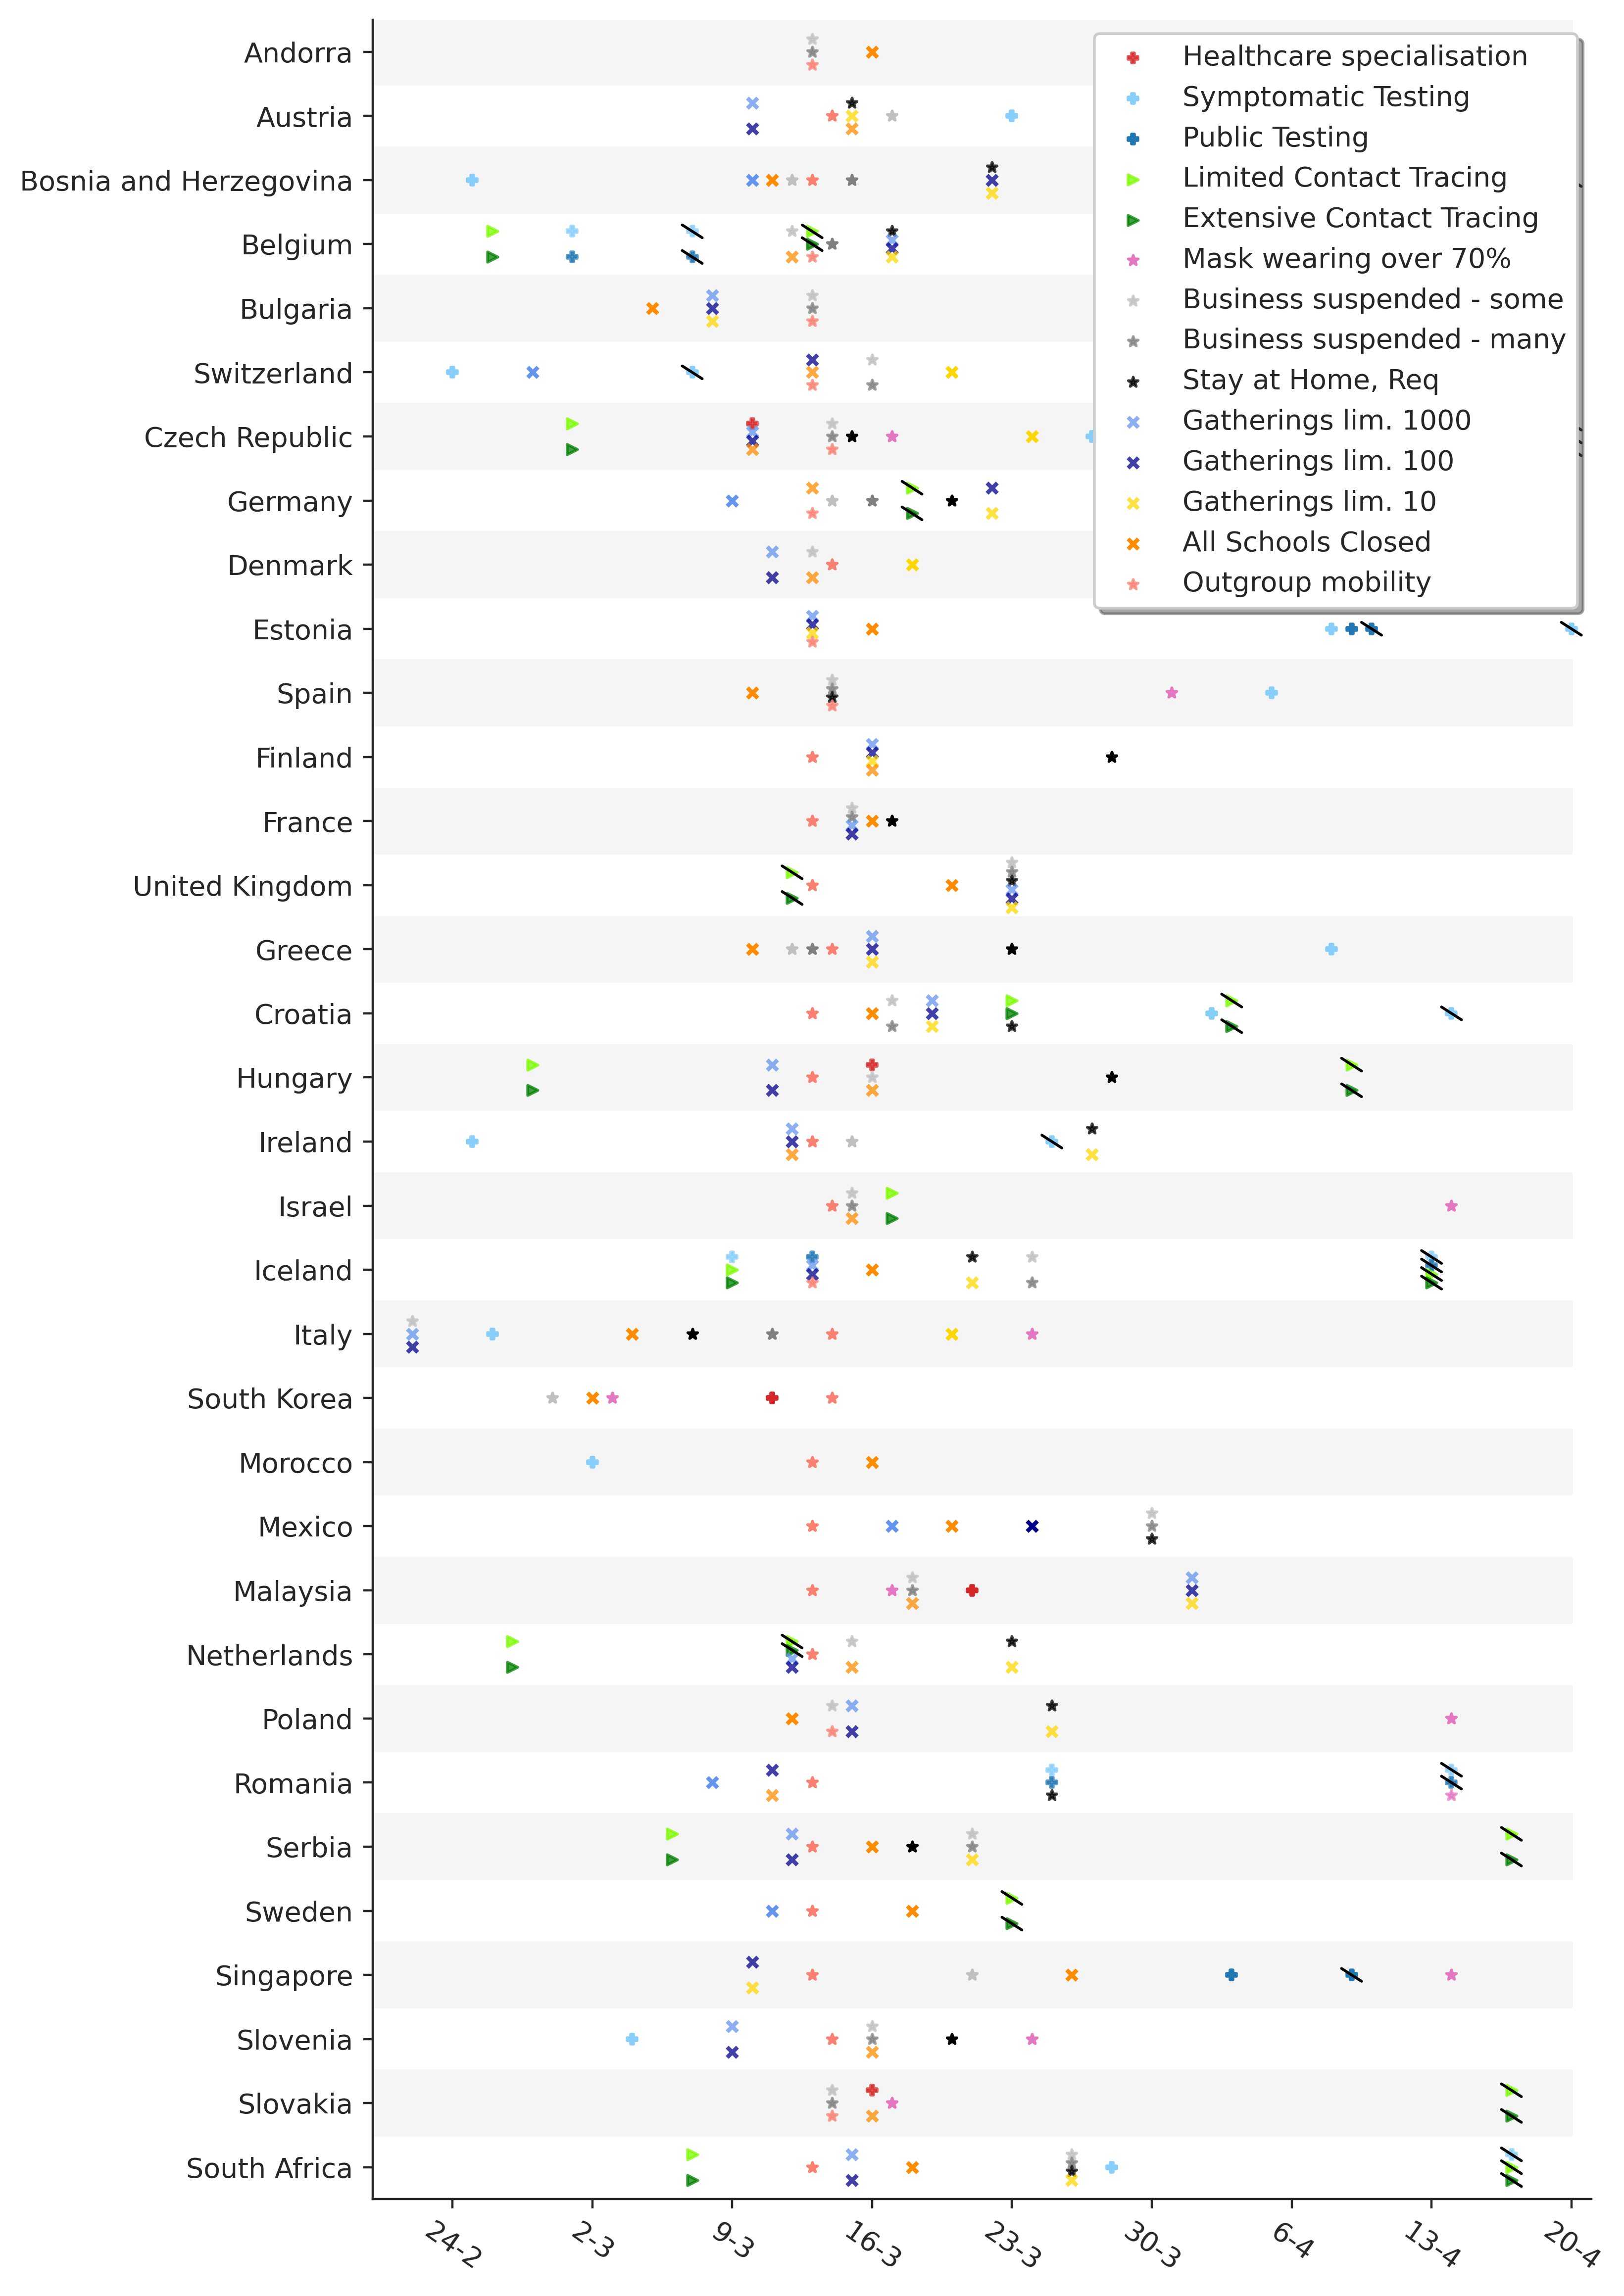

In [8]:
import seaborn as sns
sns.set_style("ticks")

region_names = list([x[0] for x in region_info])
# region_last_updt = list([x[1] for x in region_info])
     
     # why no portugal? austrailia?

plot_style = [
    ("P", "tab:red"),
    ("P", "lightskyblue"),
    ("P", "tab:blue"),
    (">", "lawngreen"),
    (">", "green"),
    ("*", "tab:pink"),
    ("*", "silver"),
    ("*", "gray"),
    ("*", "black"),
    ("x", "cornflowerblue"),
    ("x", "darkblue"),
    ("x", "gold"),
    ("x", "darkorange"),
    ("*", "salmon"),
    ("*", "tab:red")
]
        
    

    
dts = data.Ds
nDs = len(dts)
nRs = len(region_info)

x_min = 10
x_max = nDs

spread_small = 0.4
spread_large = 0.7

fig = plt.figure(figsize=(8.3, 11.7), dpi=400)

for height in range(0, nRs, 2):
    plt.fill_between(np.arange(x_min, nDs), -(height-0.5)* np.ones((nDs - x_min)), -(height+0.5)* np.ones((nDs - x_min)), color="whitesmoke")

feature_counts = np.zeros(len(final_features_ordered))
days_x = np.arange(len(dts))

ActiveCMs = data.ActiveCMs

for d_indx, region in enumerate(region_info):
    all_cm_values = ActiveCMs[d_indx, :, :]
    region_height = -d_indx
    
    all_cm_changes = np.sum((all_cm_values[:, 1:] - all_cm_values[:, :-1])!= 0 , axis=0)
    cum_changes = np.zeros(all_cm_changes.size)
    
    for indx, f in enumerate(final_features_ordered):
        cm_values = all_cm_values[indx, :]
        cm_changes = cm_values[1:] - cm_values[:-1]
        nz = (np.nonzero(cm_changes)[0]+1).tolist()
        for nz_val in nz:
            all_changes = all_cm_changes[nz_val-1]
            if all_changes > 1:
                if all_changes > 4:
                    spread = spread_large
                else:
                    spread = spread_small
                    
                height = (region_height + spread/2) - ((spread/(all_changes-1)) * cum_changes[nz_val-1])
                alpha = 0.75
                cum_changes[nz_val-1] += 1
            else:
                height = region_height
                alpha = 1
            
            if cm_changes[nz_val-1] == 1.0:
                if feature_counts[indx] == 0:
                    if indx > 0:
                        if feature_counts[indx - 1] > 0:
                            plt.scatter(nz_val, height, s=14, marker=plot_style[indx][0], color=plot_style[indx][1], label=final_features_ordered[indx], alpha=alpha)
                            feature_counts[indx] += 1
                        else:
                            plt.scatter(nz_val, height, s=14, marker=plot_style[indx][0], color=plot_style[indx][1], alpha=alpha)
                    else:
                        plt.scatter(nz_val, height, s=14, marker=plot_style[indx][0], color=plot_style[indx][1], label=final_features_ordered[indx], alpha=alpha)
                        feature_counts[indx] += 1
                else:
                    plt.scatter(nz_val, height, s=14, marker=plot_style[indx][0], color=plot_style[indx][1], alpha=alpha)
            else:
                plt.scatter(nz_val, height, s=14, marker=plot_style[indx][0], color=plot_style[indx][1], alpha=alpha)
                plt.plot([nz_val-0.5, nz_val+0.5], [height+0.1, height-0.1], linewidth=1, color="black")
            
        
locs = np.arange(0, nDs, 7)
xlabels = [f"{dts[ts].day}-{dts[ts].month}" for ts in locs]

plt.xticks(locs, xlabels, rotation=-35)
plt.xlim([x_min, x_max])
plt.yticks(-np.arange(len(region_names)), region_names)
plt.ylim([-nRs+0.5, 0.5])
plt.legend(fancybox=True, shadow=True)
sns.despine()
plt.tight_layout()